## Postprocessing techniques 
- all the 3d points are in pixel units, convert them to meters
- **Pre-filter detections**: Keep only high-confidence YOLO detections.
- **Temporal filtering**: Remove sudden 2D/3D jumps across frames.
- **Spatial filtering**: Use RANSAC or median filtering on triangulated 3D points to reject outliers.

In [4]:
import cv2
import numpy as np
import pandas as pd
import os
import glob
import json
import shutil
import sys
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def find_project_root(marker=".gitignore"):
    current = Path.cwd()
    for parent in [current] + list(current.parents):
        if (parent / marker).exists():
            return parent.resolve()
    raise FileNotFoundError(
        f"Project root marker '{marker}' not found starting from {current}")
    
root = find_project_root()

In [9]:
triangulation_results_path = f"{root}/data/stereo_detections_triangulated.csv"
triangulation_results = pd.read_csv(triangulation_results_path)
triangulation_results.sort_values(by='frame_no', inplace=True)
triangulation_results.head()

,frame_no,A1_x,A1_y,A1_confidence,A1_method,A2_x,A2_y,A2_confidence,A2_method,position_3d_pixels,A1_reprojected_point,A1_error_cm,A2_reprojected_point,A2_error_cm,anomaly_detected
0,934,1803,407,0.813748,YOLO,210,422,0.834425,YOLO,"[3748.3495057446603, -489.8600736323993, 4286....","[3551.6188659379995, 822.3109223279512]",2.647938,"[396.0710013554253, 858.9940849055374]",2.229712,False
1,935,1749,415,0.813780,YOLO,255,428,0.818114,YOLO,"[3491.8044435369134, -456.8706049838061, 4269....","[3454.0872424646295, 833.839275380029]",3.151088,"[484.3695718286685, 870.7504879470371]",2.530507,False
2,936,1698,422,0.830572,YOLO,297,435,0.594926,YOLO,"[3180.696395936944, -416.8508687861153, 4172.3...","[3358.021697409871, 845.1437835543601]",3.375053,"[568.9181872174538, 883.7010581384234]",2.507850,False
3,937,1648,432,0.856475,YOLO,297,435,0.400000,LK,"[3830.540950410358, -433.3902190764089, 5382.7...","[3270.413001279244, 875.979149815587]",0.425221,"[574.026789475392, 873.9159351645243]",0.493932,False
4,938,1647,431,0.400000,LK,297,435,0.300000,LK,"[3835.8875062889883, -437.3846201888634, 5396....","[3269.097283844382, 875.1174435073223]",0.856536,"[574.7155485073042, 872.596671803037]",0.999196,False


In [10]:
first = triangulation_results.iloc[0]
first.to_dict()

{'frame_no': 934,
 'A1_x': 1803,
 'A1_y': 407,
 'A1_confidence': 0.8137478828430176,
 'A1_method': 'YOLO',
 'A2_x': 210,
 'A2_y': 422,
 'A2_confidence': 0.834425151348114,
 'A2_method': 'YOLO',
 'position_3d_pixels': '[3748.3495057446603, -489.8600736323993, 4286.859981600735]',
 'A1_reprojected_point': '[3551.6188659379995, 822.3109223279512]',
 'A1_error_cm': 2.647937846265068,
 'A2_reprojected_point': '[396.0710013554253, 858.9940849055374]',
 'A2_error_cm': 2.2297123378325963,
 'anomaly_detected': False}

## Plot 2D reprojected points

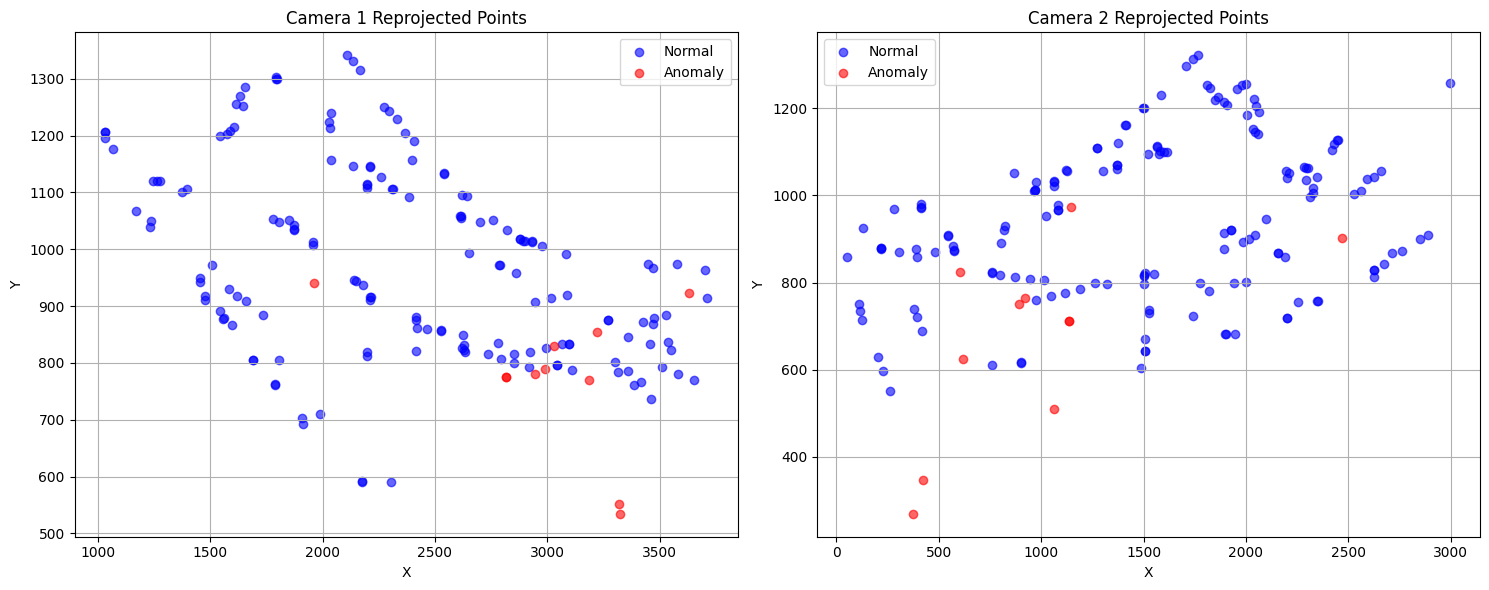

In [11]:
def plot_2d_reprojected_points(triangulation_results):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Extract points
    points_2d_1 = np.array([eval(p) for p in triangulation_results['A1_reprojected_point']])
    points_2d_2 = np.array([eval(p) for p in triangulation_results['A2_reprojected_point']])
    anomaly_mask = triangulation_results['anomaly_detected']
    
    # Plot for camera 1
    ax1.scatter(points_2d_1[~anomaly_mask, 0], points_2d_1[~anomaly_mask, 1], c='blue', alpha=0.6, label='Normal')
    ax1.scatter(points_2d_1[anomaly_mask, 0], points_2d_1[anomaly_mask, 1], c='red', alpha=0.6, label='Anomaly')
    ax1.set_title('Camera 1 Reprojected Points')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.legend()
    ax1.grid(True)
    
    # Plot for camera 2
    ax2.scatter(points_2d_2[~anomaly_mask, 0], points_2d_2[~anomaly_mask, 1], c='blue', alpha=0.6, label='Normal')
    ax2.scatter(points_2d_2[anomaly_mask, 0], points_2d_2[anomaly_mask, 1], c='red', alpha=0.6, label='Anomaly')
    ax2.set_title('Camera 2 Reprojected Points')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
plot_2d_reprojected_points(triangulation_results)

## Plot 2D original vs reprojected

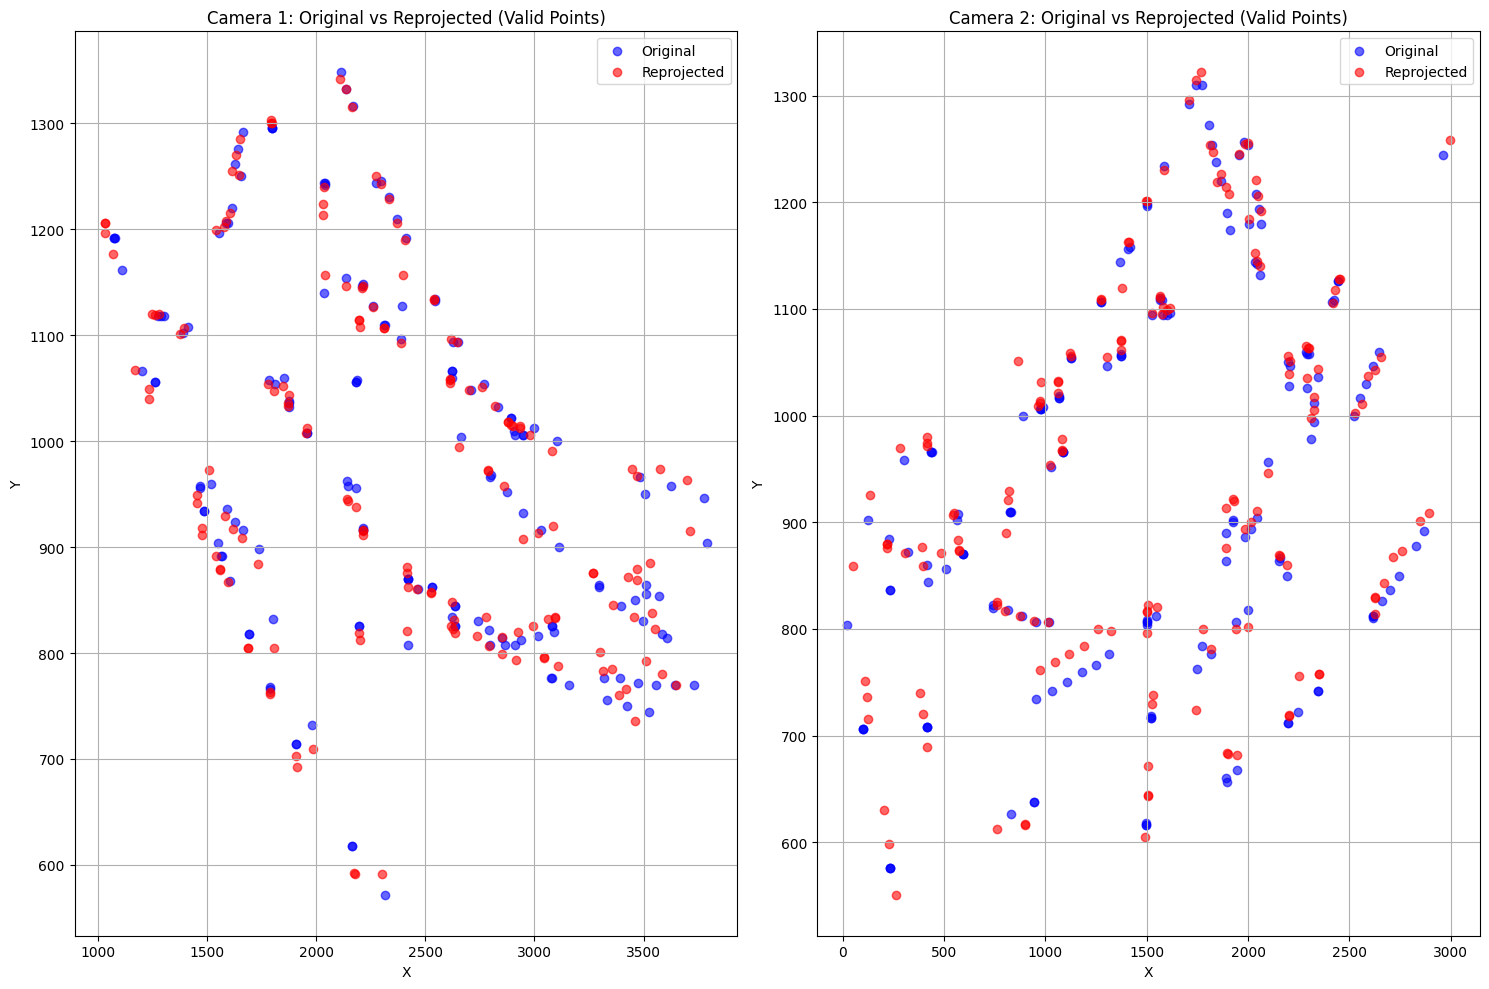

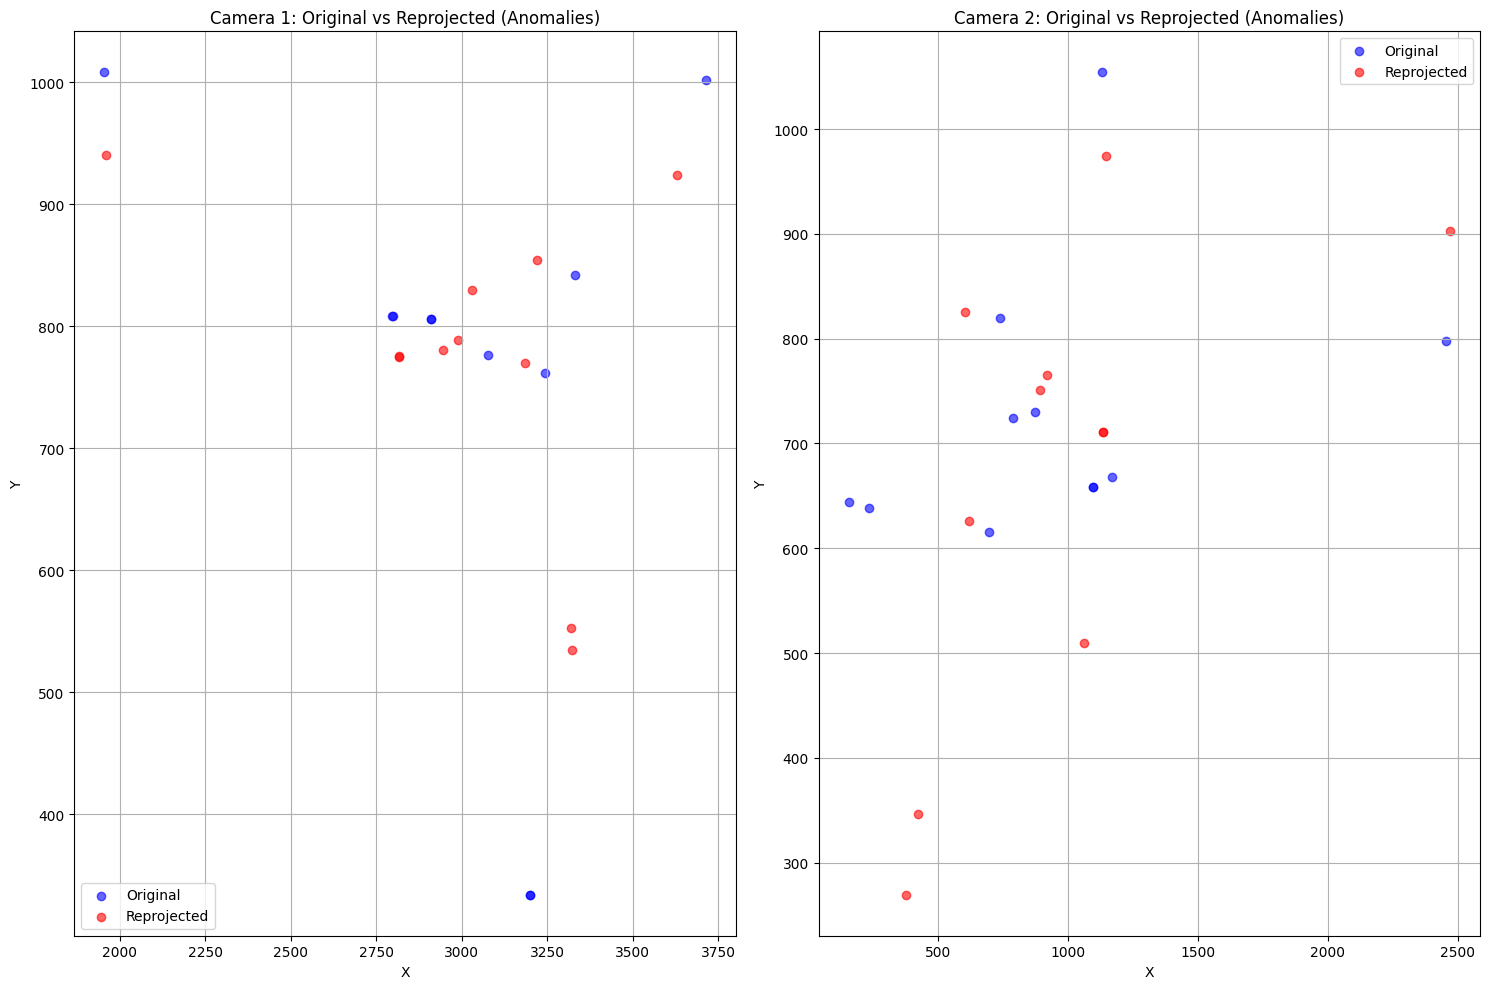

In [15]:
def plot_valid_vs_original(triangulation_results, scale_factor=2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

    # Extract points
    original_2d_1 = np.array([[row['A1_x'] * scale_factor, row['A1_y'] * scale_factor] for _, row in triangulation_results.iterrows()])
    points_2d_1 = np.array([eval(p) for p in triangulation_results['A1_reprojected_point']])
    original_2d_2 = np.array([[row['A2_x'] * scale_factor, row['A2_y'] * scale_factor] for _, row in triangulation_results.iterrows()])
    points_2d_2 = np.array([eval(p) for p in triangulation_results['A2_reprojected_point']])
    anomaly_mask = triangulation_results['anomaly_detected']
    
    
    # Plot for camera 1
    ax1.scatter(original_2d_1[~anomaly_mask, 0], original_2d_1[~anomaly_mask, 1], c='blue', alpha=0.6, label='Original')
    ax1.scatter(points_2d_1[~anomaly_mask, 0], points_2d_1[~anomaly_mask, 1], c='red', alpha=0.6, label='Reprojected')
    ax1.set_title('Camera 1: Original vs Reprojected (Valid Points)')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.legend()
    ax1.grid(True)
    
    # Plot for camera 2
    ax2.scatter(original_2d_2[~anomaly_mask, 0], original_2d_2[~anomaly_mask, 1], c='blue', alpha=0.6, label='Original')
    ax2.scatter(points_2d_2[~anomaly_mask, 0], points_2d_2[~anomaly_mask, 1], c='red', alpha=0.6, label='Reprojected')
    ax2.set_title('Camera 2: Original vs Reprojected (Valid Points)')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
  

def plot_anomaly_vs_original(triangulation_results, scale_factor=2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
    
    # Extract points
    original_2d_1 = np.array([[row['A1_x'] * scale_factor, row['A1_y'] * scale_factor] for _, row in triangulation_results.iterrows()])
    points_2d_1 = np.array([eval(p) for p in triangulation_results['A1_reprojected_point']])
    original_2d_2 = np.array([[row['A2_x'] * scale_factor, row['A2_y'] * scale_factor] for _, row in triangulation_results.iterrows()])
    points_2d_2 = np.array([eval(p) for p in triangulation_results['A2_reprojected_point']])
    anomaly_mask = triangulation_results['anomaly_detected']
    
    
    # Plot for camera 1
    ax1.scatter(original_2d_1[anomaly_mask, 0], original_2d_1[anomaly_mask, 1], c='blue', alpha=0.6, label='Original')
    ax1.scatter(points_2d_1[anomaly_mask, 0], points_2d_1[anomaly_mask, 1], c='red', alpha=0.6, label='Reprojected')
    ax1.set_title('Camera 1: Original vs Reprojected (Anomalies)')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.legend()
    ax1.grid(True)
    
    # Plot for camera 2
    ax2.scatter(original_2d_2[anomaly_mask, 0], original_2d_2[anomaly_mask, 1], c='blue', alpha=0.6, label='Original')
    ax2.scatter(points_2d_2[anomaly_mask, 0], points_2d_2[anomaly_mask, 1], c='red', alpha=0.6, label='Reprojected')
    ax2.set_title('Camera 2: Original vs Reprojected (Anomalies)')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
  
plot_valid_vs_original(triangulation_results)
plot_anomaly_vs_original(triangulation_results)

## Plot 3D points and anomalies in different color

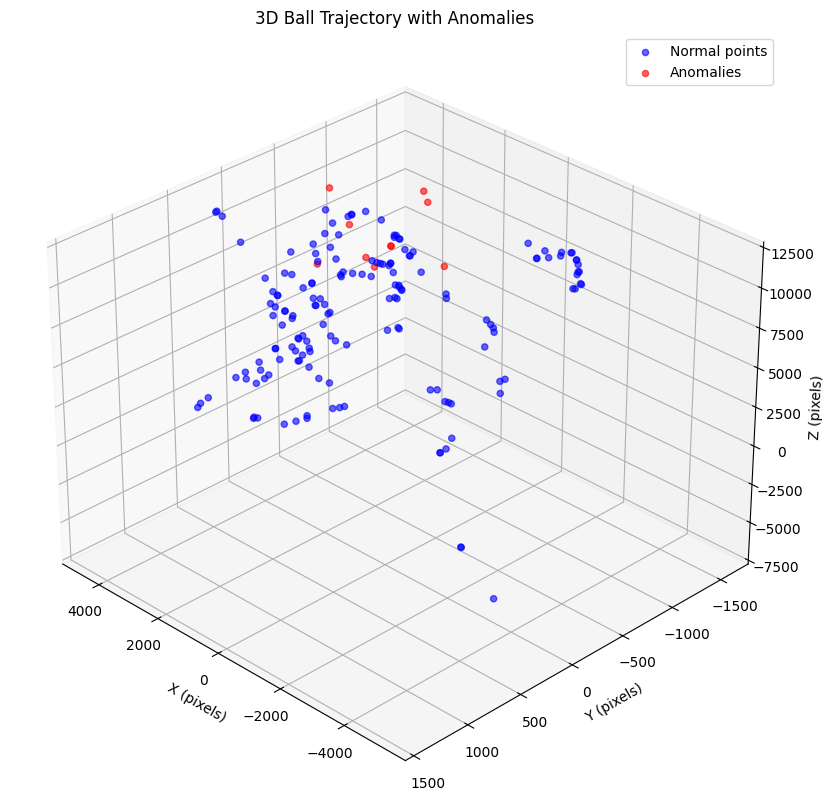

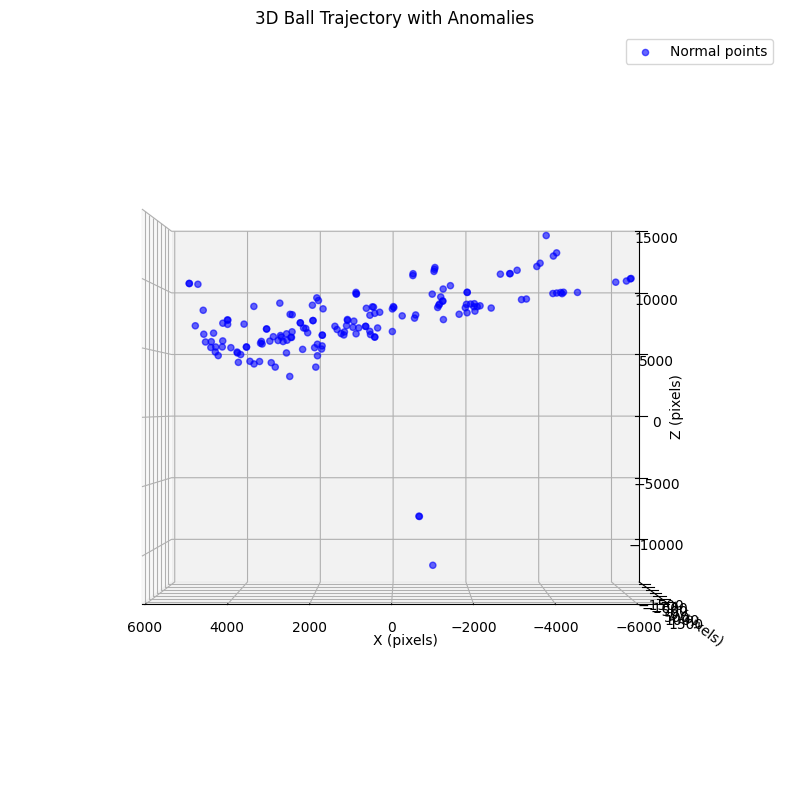

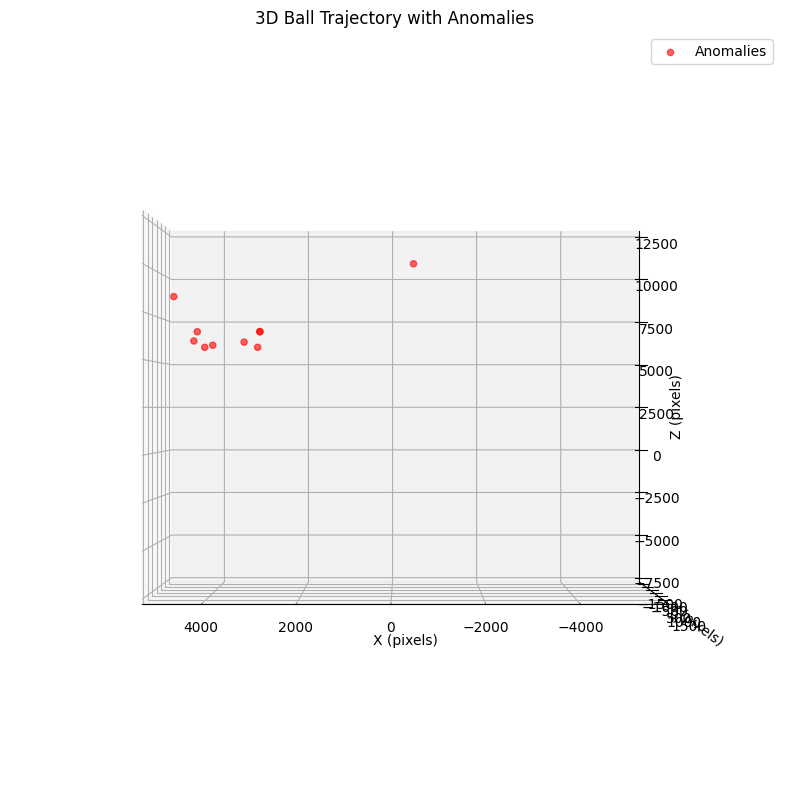

In [34]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def plot_3d_points_with_anomalies(triangulation_results):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Extract 3D points and separate normal points from anomalies
    points_3d = np.array([eval(p) for p in triangulation_results['position_3d_pixels']])
    normal_mask = ~triangulation_results['anomaly_detected']
    anomaly_mask = triangulation_results['anomaly_detected']

    # Plot normal points in blue
    ax.scatter(points_3d[normal_mask, 0],
               points_3d[normal_mask, 1],
               points_3d[normal_mask, 2],
               c='blue', label='Normal points', alpha=0.6)

    # Plot anomalies in red
    ax.scatter(points_3d[anomaly_mask, 0],
               points_3d[anomaly_mask, 1],
               points_3d[anomaly_mask, 2],
               c='red', label='Anomalies', alpha=0.6)

    # Customize the plot
    ax.set_xlabel('X (pixels)')
    ax.set_ylabel('Y (pixels)')
    ax.set_zlabel('Z (pixels)')
    ax.set_title('3D Ball Trajectory with Anomalies')
    ax.legend()
    ax.grid(True)
    # ax.view_init(elev=0, azim=90)    # side view
    # ax.view_init(elev=90, azim=0)    # top view
    ax.view_init(elev=30, azim=135)  # diagonal view
    ax.dist = 2  # Adjust zoom level (lower number = more zoom)
    percentile = 99  # adjust between 90-99 to include more/less points
    ax.set_xlim(np.percentile(points_3d[:, 0], [100-percentile, percentile]))
    ax.set_ylim(np.percentile(points_3d[:, 1], [100-percentile, percentile]))
    ax.set_zlim(np.percentile(points_3d[:, 2], [100-percentile, percentile]))
    plt.show()


def plot_3d_filtered_points(triangulation_results):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Extract 3D points and separate normal points from anomalies
    points_3d = np.array([eval(p) for p in triangulation_results['position_3d_pixels']])
    normal_mask = ~triangulation_results['anomaly_detected']

    # Plot normal points in blue
    ax.scatter(points_3d[normal_mask, 0],
               points_3d[normal_mask, 1],
               points_3d[normal_mask, 2],
               c='blue', label='Normal points', alpha=0.6)

    # Customize the plot
    ax.set_xlabel('X (pixels)')
    ax.set_ylabel('Y (pixels)')
    ax.set_zlabel('Z (pixels)')
    ax.set_title('3D Ball Trajectory with Anomalies')
    ax.legend()
    ax.grid(True)
    ax.view_init(elev=0, azim=90)    # side view
    # ax.view_init(elev=90, azim=0)    # top view
    # ax.view_init(elev=30, azim=135)  # diagonal view
    ax.dist = 2  # Adjust zoom level (lower number = more zoom)
    plt.show()


def plot_3d_anomalies_points(triangulation_results):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Extract 3D points and separate normal points from anomalies
    points_3d = np.array([eval(p) for p in triangulation_results['position_3d_pixels']])
    anomaly_mask = triangulation_results['anomaly_detected']

    # Plot anomalies in red
    ax.scatter(points_3d[anomaly_mask, 0],
               points_3d[anomaly_mask, 1],
               points_3d[anomaly_mask, 2],
               c='red', label='Anomalies', alpha=0.6)

    # Customize the plot
    ax.set_xlabel('X (pixels)')
    ax.set_ylabel('Y (pixels)')
    ax.set_zlabel('Z (pixels)')
    ax.set_title('3D Ball Trajectory with Anomalies')
    ax.legend()
    ax.grid(True)
    ax.view_init(elev=0, azim=90)    # side view
    # ax.view_init(elev=90, azim=0)    # top view
    # ax.view_init(elev=30, azim=135)  # diagonal view
    ax.dist = 2  # Adjust zoom level (lower number = more zoom)
    percentile = 99  # adjust between 90-99 to include more/less points
    ax.set_xlim(np.percentile(points_3d[:, 0], [100-percentile, percentile]))
    ax.set_ylim(np.percentile(points_3d[:, 1], [100-percentile, percentile]))
    ax.set_zlim(np.percentile(points_3d[:, 2], [100-percentile, percentile]))
    plt.show()


plot_3d_points_with_anomalies(triangulation_results)
plot_3d_filtered_points(triangulation_results)
plot_3d_anomalies_points(triangulation_results)

## RANSAC
- separate the data into inliear set and outlier set
- focus on inliar in the Z (depth)

In [7]:
from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


def ransac_filter_3d_points(points_3d, max_iterations=100, threshold=0.1):
    """
    Apply RANSAC to filter 3D points by fitting a polynomial trajectory.
    points_3d: numpy array of shape (3, N) containing X,Y,Z coordinates
    max_iterations: number of RANSAC iterations
    threshold: maximum distance from polynomial to consider a point inlier. 
    smaller is more strict
    """
    # Prepare data: use frame numbers as X and each coordinate as Y
    n_points = points_3d.shape[1]
    X = np.arange(n_points).reshape(-1, 1)
    
    # Create polynomial features
    degree = 2  # quadratic trajectory
    poly = PolynomialFeatures(degree=degree)
    
    # Fit RANSAC for each coordinate
    inliers = np.ones(n_points, dtype=bool)
    for coord in range(3):  # X, Y, Z
        y = points_3d[coord]
        ransac = RANSACRegressor(
            random_state=42,
            max_trials=max_iterations,
            residual_threshold=threshold
        )
        model = make_pipeline(poly, ransac)
        model.fit(X, y)
        inliers &= ransac.inlier_mask_
    
    return points_3d[:, inliers], inliers

In [13]:
print(len(triangulation_results))

points_list = []
for _, row in triangulation_results.iterrows():
    pts = eval(row['position_3d_pixels'])
    points_list.append(pts)


points_3d = np.array(points_list).T  

filtered_points, inliers_mask = ransac_filter_3d_points(points_3d, threshold=1000)

print(len(filtered_points))

101
3


In [11]:
filtered_points

array([[ 3830.54095041,  4318.91796926,  2894.12212253,  2793.02592409,
         3030.33269241,  3243.89640286,  3464.11748539,  3442.13566137,
         4466.19001502,  4514.39631659,  3068.34478662, -4075.95545696,
        -4173.41564742],
       [ -433.39021908,  -375.63248221,  -176.77446406,  -706.46603979,
         -688.06747269,  -658.87813024,  -631.1078881 ,  -606.35210622,
         -423.78196043, -1004.05651201,  -982.34245116,   674.36166228,
          672.80986006],
       [ 5382.76462145,  7134.10779018,  6113.60491424,  5959.3709854 ,
         5935.01667262,  5882.08028953,  5853.81274672,  5647.67496816,
         5392.21631295,  6818.74097577,  6825.87940621,  9236.43946186,
         9273.78150509]])

In [12]:
inliers_mask

array([False, False, False,  True,  True, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True,  True,  True,  True, False,  True, False, False,
       False,  True, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True, False])